
# Prognozowanie zużycia energii na podstawie właściwości budynku oraz czynników środowiskowych

**Autor**: Jakub Kucharzewski

**Data**: 2025-06-09


# Wprowadzenie

Celem niniejszej analizy jest zbudowanie modelu regresji liniowej służącego do prognozowania zużycia energii na podstawie cech budynków oraz wybranych czynników środowiskowych.

Wykorzystany zbiór danych pochodzi z platformy Kaggle i zawiera informacje dotyczące różnych typów budynków, ich powierzchni użytkowej, liczby użytkowników, liczby używanych urządzeń, średniej temperatury otoczenia oraz dnia tygodnia.

# Wczytanie i eksploracja danych

Na początku wczytałem dane treningowe i testowe, a następnie sprawdziłem ich typy zmiennych oraz liczbę obserwacji. Zidentyfikowałem ewentualne brakujące wartości i przeanalizowałem podstawowe statystyki opisowe.

Użyte biblioteki: ggplot2, corrplot, DescTools, MASS, rlang, ggfortify.

In [9]:
energy_data <- read.csv("train_energy_data.csv")
energy_test_data <- read.csv("test_energy_data.csv")

head(energy_data)

,Building.Type,Square.Footage,Number.of.Occupants,Appliances.Used,Average.Temperature,Day.of.Week,Energy.Consumption
,<chr>,<int>,<int>,<int>,<dbl>,<chr>,<dbl>
1,Residential,7063,76,10,29.84,Weekday,2713.95
2,Commercial,44372,66,45,16.72,Weekday,5744.99
3,Industrial,19255,37,17,14.30,Weekend,4101.24
4,Residential,13265,14,41,32.82,Weekday,3009.14
5,Commercial,13375,26,18,11.92,Weekday,3279.17
6,Commercial,37377,26,32,16.24,Weekend,4687.67


### Suma pustych wartości

In [17]:
colSums(is.na(energy_data))

Building.Type      Square.Footage Number.of.Occupants     Appliances.Used 
                  0                   0                   0                   0 
Average.Temperature         Day.of.Week  Energy.Consumption 
                  0                   0                   0

### Statystyki opisowe

In [16]:
summary(energy_data)

     Building.Type Square.Footage  Number.of.Occupants Appliances.Used
 Commercial :336   Min.   :  560   Min.   : 1.00       Min.   : 1.00  
 Industrial :317   1st Qu.:13170   1st Qu.:22.00       1st Qu.:13.00  
 Residential:347   Median :25477   Median :47.00       Median :26.00  
                   Mean   :25462   Mean   :48.37       Mean   :25.61  
                   3rd Qu.:37446   3rd Qu.:73.25       3rd Qu.:38.00  
                   Max.   :49997   Max.   :99.00       Max.   :49.00  
 Average.Temperature  Day.of.Week  Energy.Consumption
 Min.   :10.05       Weekday:507   Min.   :1684      
 1st Qu.:16.48       Weekend:493   1st Qu.:3509      
 Median :22.82                     Median :4176      
 Mean   :22.61                     Mean   :4166      
 3rd Qu.:28.85                     3rd Qu.:4864      
 Max.   :34.99                     Max.   :6531      

### Typy danych

In [18]:
str(energy_data)

'data.frame':	1000 obs. of  7 variables:
 $ Building.Type      : Factor w/ 3 levels "Commercial","Industrial",..: 3 1 2 3 1 1 2 3 2 3 ...
 $ Square.Footage     : int  7063 44372 19255 13265 13375 37377 38638 34950 29741 17467 ...
 $ Number.of.Occupants: int  76 66 37 14 26 26 92 60 99 42 ...
 $ Appliances.Used    : int  10 45 17 41 18 32 14 18 44 36 ...
 $ Average.Temperature: num  29.8 16.7 14.3 32.8 11.9 ...
 $ Day.of.Week        : Factor w/ 2 levels "Weekday","Weekend": 1 1 2 1 1 2 2 1 1 1 ...
 $ Energy.Consumption : num  2714 5745 4101 3009 3279 ...


### Zmiana zmiennych kategorycznych na typ faktorowy

Zmienne kategoryczne przekonwertowałem na typ faktorowy, aby móc uwzględnić je w modelu regresji liniowej.

In [15]:
energy_data$Day.of.Week <- as.factor(energy_data$Day.of.Week)
energy_data$Building.Type <- as.factor(energy_data$Building.Type)
energy_test_data$Day.of.Week <- as.factor(energy_test_data$Day.of.Week)
energy_test_data$Building.Type <- as.factor(energy_test_data$Building.Type)

# Analiza eksploracyjna i wizualizacja

W celu zidentyfikowania zależności liniowych pomiędzy zmiennymi objaśniającymi a zużyciem energii, przeprowadziłem testy istotności współczynnika korelacji Pearsona. Testy pozwalają ocenić, czy istnieje statystycznie istotna korelacja między zmiennymi.

### Test istotności współczynnika korelacji Pearsona
|                             |                                       |
|-----------------------------|---------------------------------------|
| ***Hipoteza zerowa***       | Brak korelacji między zmiennymi.      |
| ***Hipoteza alternatywna*** | Korelacja występuje między zmiennymi. |
| ***Poziom istotności***     | 0.05                                  |

**Wartość p:** Wartość p oznacza prawdopodobieństwo otrzymania wyniku tak samo lub bardziej skrajnego niż ten zaobserwowany w badaniu, przy założeniu, że hipoteza zerowa jest prawdziwa.

**Interpretacja:** Gdy wartość p jest większa niż 0,05, nie ma podstaw do odrzucenia hipotezy zerowej. Natomiast jeśli wartość p jest równa lub mniejsza od 0,05, odrzucamy hipotezę zerową na rzecz hipotezy alternatywnej.

In [19]:
num_data <- energy_data[sapply(energy_data, is.numeric)]
vars = subset(num_data, select = -c(Energy.Consumption))
vars_names <- names(vars)

for (var in vars_names) {
  test <- cor.test(energy_data$Energy.Consumption, vars[[var]])
  print(test)
}

[1] "Square.Footage"      "Number.of.Occupants" "Appliances.Used"    
[4] "Average.Temperature"

	Pearson's product-moment correlation

data:  energy_data$Energy.Consumption and vars[[var]]
t = 38.726, df = 998, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.7488519 0.7985080
sample estimates:
      cor 
0.7748726 


	Pearson's product-moment correlation

data:  energy_data$Energy.Consumption and vars[[var]]
t = 11.976, df = 998, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2990637 0.4075222
sample estimates:
      cor 
0.3544847 


	Pearson's product-moment correlation

data:  energy_data$Energy.Consumption and vars[[var]]
t = 10.403, df = 998, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2557580 0.3676556
sample estimates:
      cor 
0.3127917 


	Pearson's product-moment correlation

dat


***Wynik testu***:

-   **Powierzchnia budynku, liczba mieszkańców oraz liczba używanych urządzeń**: bardzo niskie wartości p wskazują, że należy odrzucić hipotezę zerową, co oznacza **istnieje istotna statystycznie korelacja** między tymi zmiennymi a zużyciem energii.

-   **Średnia temperatura**: Wartość p = 0.2759 jest znacznie większa niż przyjęty poziom istotności (0.05), co oznacza, że **nie ma podstaw do odrzucenia hipotezy zerowej**. W tym przypadku nie można potwierdzić istnienia istotnej korelacji między średnią temperaturą a zużyciem energii.

| Zmienna                   | Parametr t | p-value    |
|---------------------------|------------|------------|
| Powierzchnia budynku      | 38.726     | \< 2.2e-16 |
| Liczba mieszkańców        | 11.976     | \< 2.2e-16 |
| Liczba używanych urządzeń | 10.403     | \< 2.2e-16 |
| Średnia temperatura       | -1.0901    | 0.2759     |


### Macierz korelacji
Przedstawiona graficznie macierz informuje nas o wartościach współczynników korelacji Pearsona między zmiennymi.

***Interpretacja***: Wartości o barwach niebieskich oznaczają dodatnią korelację między zmiennymi, natomiast te czerwone ujemną. Im ciemniejszy kolor tym wyższy współczynnik.

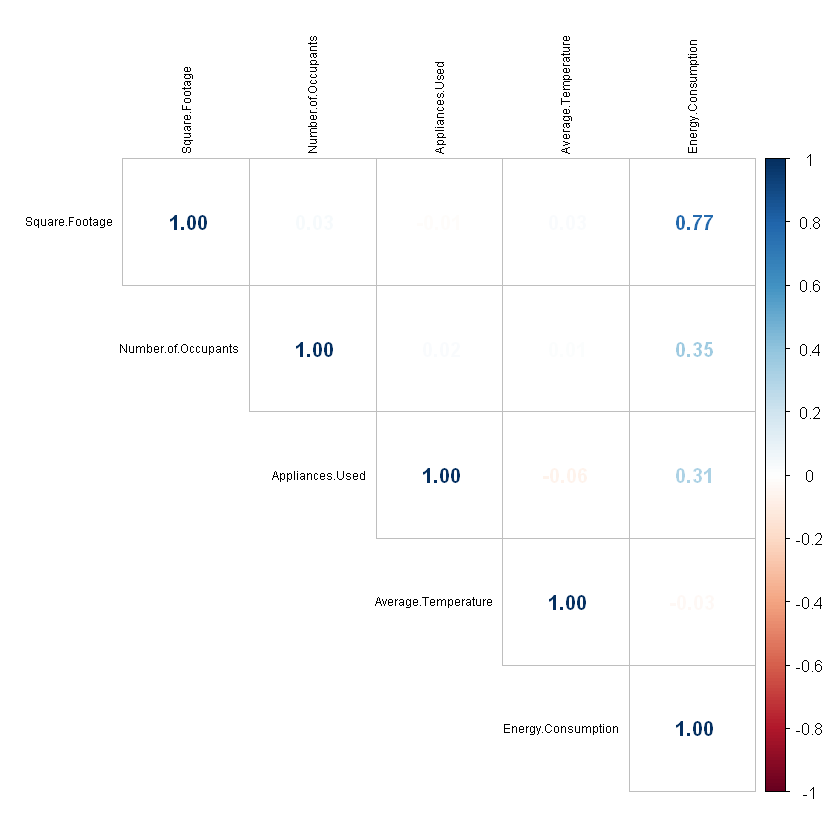

In [21]:
cor_matrix_num <- cor(num_data, use = "complete.obs", method = "pearson")
corrplot(cor_matrix_num, method = "number", type = "upper", tl.cex = 0.6, tl.col = "black")

# Model regresji liniowej

Teraz utworzę model regresji liniowej korzystając ze zmiennych numerycznych, które wykazały korelacje w testach powyżej, oraz tych pozostałych - kategorycznych. Za pomocą funkcji summary, ocenię ich istotność.

***Interpretacja***:

-   **Gwiazdki przy zmiennych** to wizualne oznaczenie, które pomaga szybko zorientować się, które zmienne są istotne.

    Znaczenie symboli:

| Symbol     | Zakres wartości p |
|------------|-------------------|
| " **\*\*\*** " | p \< 0.001        |
| " **\*\*** "   | 0.001 ≤ p \< 0.01 |
| " **\*** "     | 0.01 ≤ p \< 0.05  |
| " **.** "      | 0.05 ≤ p \< 0.1   |
| " "        | p ≥ 0.1           |

-   **R-squared** i **Adjusted R-squared** to miary statystyczne w modelu regresji, które pokazują, jaki procent zmienności zmiennej zależnej można wytłumaczyć na podstawie zmiennych niezależnych.

    R-squared zawsze rośnie lub pozostaje bez zmian, gdy dodajesz nowe zmienne, nawet jeśli są one nieistotne. Adjusted R-squared to zmodyfikowana wersja R-squared, która koryguje wynik, biorąc pod uwagę liczbę zmiennych i liczbę obserwacji. Może zmaleć, jeśli dodasz zmienną, która nie wnosi istotnej informacji.

-   **Residual standard error** to przeciętna różnica między przewidywanymi a rzeczywistymi wartościami.

In [22]:
model <- lm(Energy.Consumption ~ 
     Square.Footage +
     Number.of.Occupants + 
     Appliances.Used +
     Building.Type + 
     Day.of.Week, data = energy_data)

summary(model)


Call:
lm(formula = Energy.Consumption ~ Square.Footage + Number.of.Occupants + 
    Appliances.Used + Building.Type + Day.of.Week, data = energy_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-64.280 -31.435  -0.629  29.609  68.235 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               1.937e+03  4.027e+00  480.95   <2e-16 ***
Square.Footage            4.994e-02  7.917e-05  630.80   <2e-16 ***
Number.of.Occupants       9.982e+00  3.891e-02  256.56   <2e-16 ***
Appliances.Used           2.016e+01  8.012e-02  251.59   <2e-16 ***
Building.TypeIndustrial   4.973e+02  2.799e+00  177.67   <2e-16 ***
Building.TypeResidential -5.031e+02  2.736e+00 -183.89   <2e-16 ***
Day.of.WeekWeekend       -4.918e+01  2.259e+00  -21.77   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 35.69 on 993 degrees of freedom
Multiple R-squared:  0.9985,	Adjusted R-squared:  0.9985 
F-statistic:

***Wyniki***:

-   Przy każdej zmiennej pokazał się symbol **\*\*\***, co świadczy o bardzo niskich wartościach p. Każda zmienna jest istotna statystycznie.

-   ***R-squared*****:** 0.9985**, *Adjusted R-squared*:** 0.9985

    To oznacza, że model tłumaczy aż **99.85% zmienności zużycia energii**, co jest bardzo wysoką wartością. Może to świadczyć o bardzo dobrym dopasowaniu lub przeuczeniu (overfitting), czyli sytuacji, gdy model bardzo dobrze przewiduje dane treningowe, natomiast w przypadku tych testowych wypada dużo gorzej.

-   ***Residual standard error***: 35.69

    W kontekście skali danych jest to bardzo mała wartość, zatem różnice między wartościami prawdziwymi a przewidzianymi są małe.

# Założenia regresji liniowej

Sprawdzanie założeń regresji liniowej jest kluczowe, ponieważ gwarantuje wiarygodność i trafność wniosków wyciąganych z modelu. Jeśli te założenia są naruszone, wyniki mogą być błędne lub mylące.

### Założenia

1.  ***Liniowość***: związek miedzy zmiennymi niezależnymi a zależną jest liniowy.

2.  ***Homoskedastyczność reszt***: reszty mają stałą wariancję na wszystkich poziomach zmiennych niezależnych.

3.  **Niezależność obserwacji**: brak autokorelacji pomiędzy resztami.

4.  ***Normalność reszt***: reszty mają rozkład normalny.

5.  ***Brak wielokolinearności***: Zmienne niezależne nie są ze sobą silnie skorelowane.

### Wizualizacja diagnostyczna modelu

Do sprawdzenia założeń regresji liniowej niezbędny będzie zestaw czterech standardowych wykresów diagnostycznych.

1.  **Residuals vs Fitted**

    Ten wykres służy do oceny **liniowości** modelu oraz wstępnego sprawdzenia **jednorodności wariancji** reszt.

    Jeśli reszty są losowo rozproszone wokół poziomej linii (na poziomie 0), bez wyraźnych wzorców, sugeruje to, że:

    -   model dobrze odwzorowuje **liniową zależność**,

    -   spełnia założenie **homoskedastyczności** (stałej wariancji).

    Jeśli reszty tworzą wzory (np. krzywą), może to świadczyć o:

    -   **nieliniowości** modelu,
    -   **heteroskedastyczności** (zmiennej wariancji reszt).

2.  **Normal Q-Q**

    Ten wykres ocenia, czy **reszty mają rozkład normalny**.

    Jeśli punkty układają się wzdłuż przekątnej (linii prostej), oznacza to, że rozkład reszt jest zbliżony do **normalnego**.

    Odchylenia od linii, zwłaszcza na końcach, mogą wskazywać na:

    -   **asymetrię rozkładu reszt**,

    -   obecność **wartości odstających**.

3.  **Scale-Location (Spread-Location)**

    Wykres ten precyzyjniej sprawdza **homoskedastyczność** reszt.

    Pokazuje pierwiastek z wartości bezwzględnych standaryzowanych reszt względem wartości dopasowanych.

    -   Jeśli punkty są równomiernie rozproszone wokół poziomej linii i nie tworzą wzorca (np. wachlarza czy lejka), oznacza to, że **wariancja reszt jest stała**.

    -   Wzrost lub spadek rozrzutu sugeruje **heteroskedastyczność**.

4.  **Residuals vs Leverage**

    Ten wykres identyfikuje **obserwacje mające duży wpływ na model**, czyli tzw. punkty wpływowe (*influential points*).

    Oś X: **wpływ** - miara "odległości" obserwacji od średnich wartości zmiennych niezależnych.

    Oś Y: **standaryzowane reszty** - jak bardzo obserwacja odbiega od wartości przewidywanej.

    Obserwacje o:

    -   **dużym wpływ**,

    -   **dużych resztach**

        mogą nadmiernie wpływać na kształt modelu, zatem należy je dokładniej zbadać.

    Jeśli pojawią się punkty znacznie oddalone od reszty (oznaczone numerami), warto sprawdzić, czy nie są to **wartości odstające lub błędne dane**.

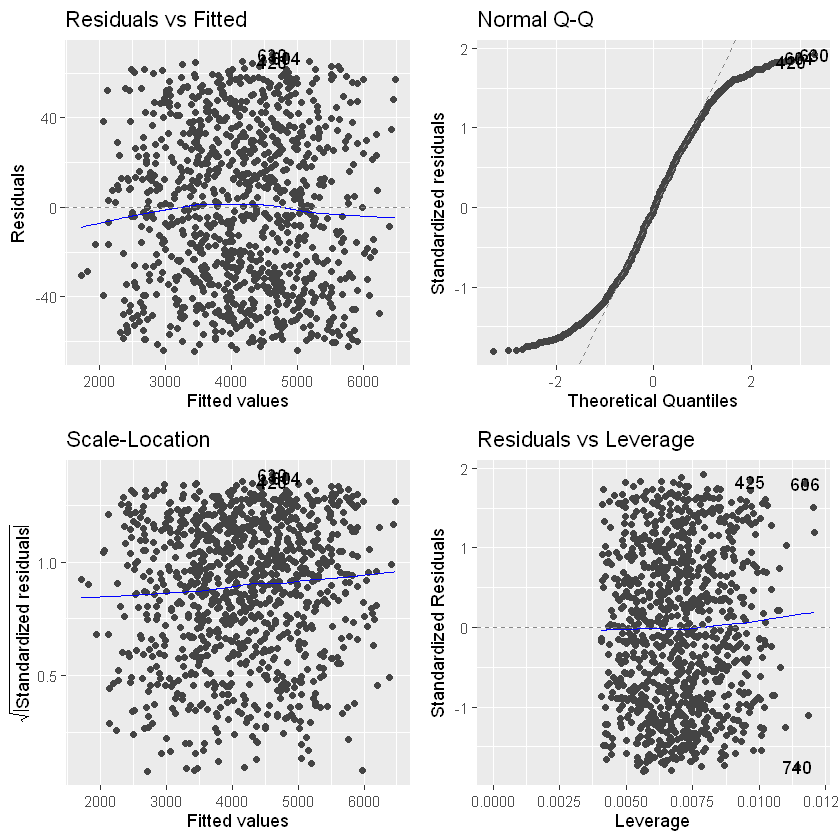

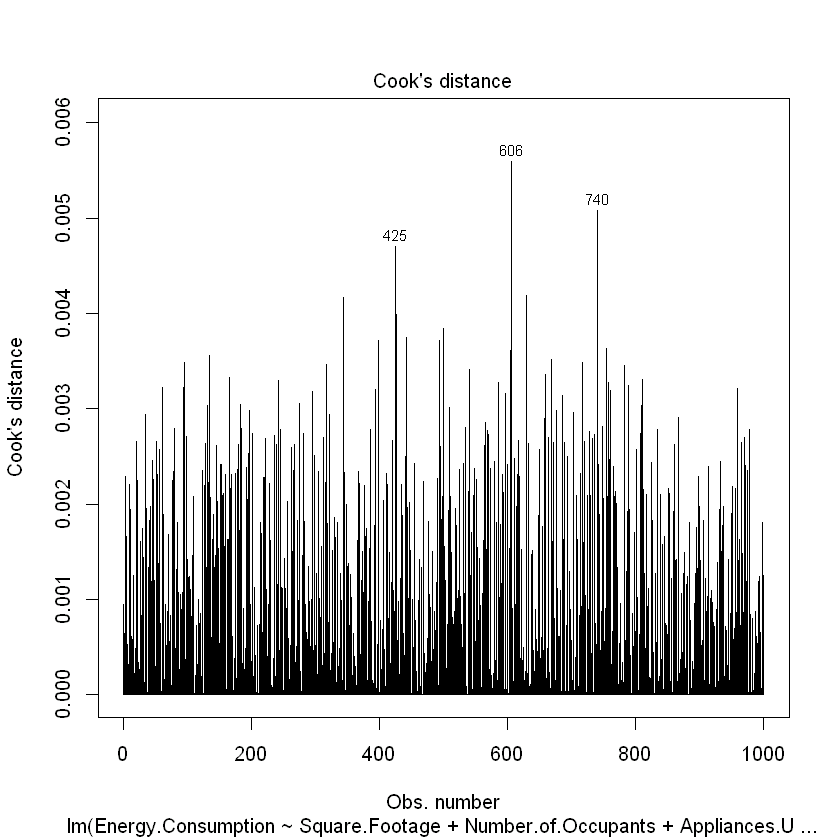

In [26]:
autoplot(model)
plot(model, which = 4)

***Wyniki***:

-   **Residuals vs Fitted**: Punkty są rozproszone losowo i równomiernie, nie tworzą żadnych wzorców. Sugeruje to, że założenia o homoskedastyczności i liniowości są zasadne.

-   **Normal Q-Q**: Punkty nie ustawiają się idealnie na linii prostej, widać wyraźne odchylenia na końcach wykresów. Może to świadczyć o tym, że rozkład reszt jest nieco spłaszczony i nie formuje się idealnie w rozkład normalny.

-   **Scale-Location**: Ponownie punkty są rozproszone równomiernie i nie tworzą wzorców, co jest korzystne dla założenia o homoskedastyczności.

-   **Residuals vs Leverage**: Punkty 425, 606, 740 zostały automatycznie oznaczone, co oznacza, że mają trochę większy wpływ lub reszty. Jednak na wykresie **Cooks** distance widać, że nie są znacząco wyższe niż reszta, a ich usunięcie nie wiele by zmieniło.

### Test Shapiro-Wilka

Wykonam test Shapiro-Wilka, aby dokładnie zbadać normalność rozkładu reszt.
|                             |                                       |
|-----------------------------|---------------------------------------|
| ***Hipoteza zerowa***       | Rozkład reszt jest normalny. (p \> 0.05)         |
| ***Hipoteza alternatywna*** |Rozkład reszt różni się od normalnego (p \< 0.05).|
| ***Poziom istotności***     | 0.05                                  |


	Shapiro-Wilk normality test

data:  sample(residuals, 500)
W = 0.95895, p-value = 1.386e-10


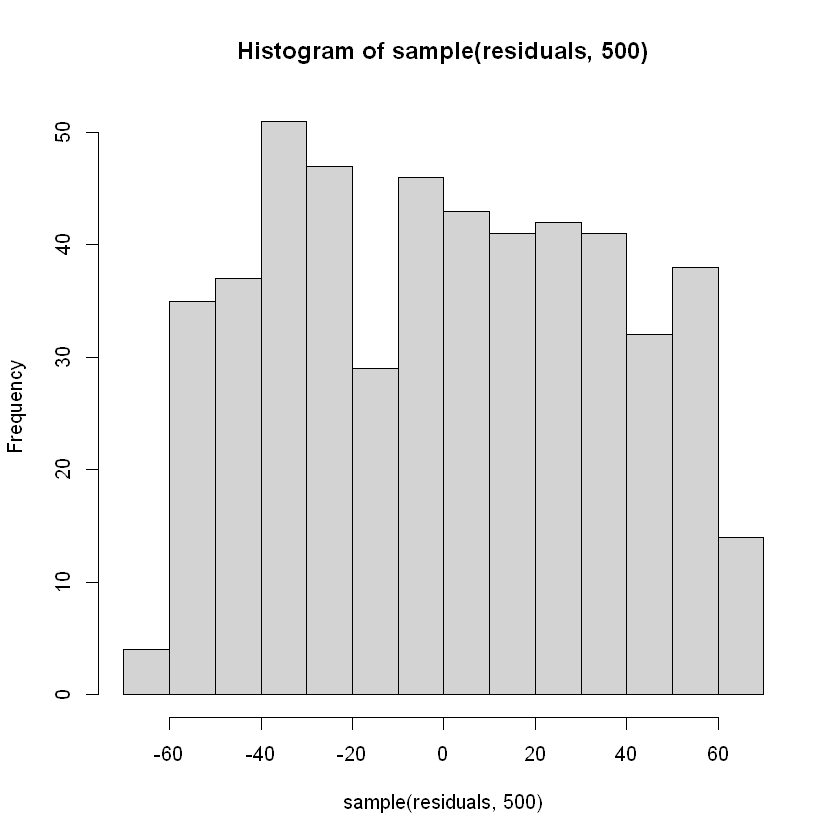

In [29]:
residuals = residuals(model)
hist(sample(residuals, 500))

set.seed(432)
shapiro.test(sample(residuals, 500))

***Wynik***:

-   Na histogramie widzać, że rozkład jest spłaszczony i znacząco różni się od normalnego.

-   Test Shapiro-Wilka zwrócił wartość p = 1.076e-10 \< 0.05, zatem istnieje powód do odrzucenia hipotezy zerowej na rzecz alternatywnej.

### Test Durbina-Watsona

Aby zbadać **niezależność obserwacji** korzystam z testu Durbina-Watsona

***Poziom istotności***: 0.05

***Hipoteza zerowa***: Nie ma autokorelacji pomiędzy resztami (p \> 0.05).

***Hipoteza alternatywna***: Reszty są autokorelowane (p \< 0.05).

In [31]:
library(lmtest)
dwtest(model)


	Durbin-Watson test

data:  model
DW = 2.0668, p-value = 0.8546
alternative hypothesis: true autocorrelation is greater than 0


***Wynik***:

-   Wartość p = 0.8546 \> 0.05, nie ma powodu do odrzucenia hipotezy zerowej.

### Podsumowanie powyższych wyników

-   **Liniowość**: wykres *Residuals vs Fitted* nie wykazuje nieliniowych wzorców, co sugeruje poprawność założenia liniowości.
-   **Homoskedastyczność**: rozkład reszt na wykresach *Residuals vs Fitted* oraz *Scale-Location* nie wskazuje na zmienność wariancji - reszty są równomiernie rozproszone.
-   **Niezależność obserwacji**: test Durbina-Watsona nie wykazał autokorelacji reszt (p = 0.8546 \> 0.05), co potwierdza spełnienie założenia.
-   **Normalność reszt**: wykres Q-Q sugeruje pewne odchylenia od rozkładu normalnego, co zostało potwierdzone testem Shapiro-Wilka (p \< 0.05). Oznacza to, że rozkład reszt nie jest w pełni normalny, co warto mieć na uwadze przy interpretacji wyników.
-   **Brak wielokolinearności**: macierz korelacji nie wykazała silnych korelacji pomiędzy zmiennymi niezależnymi, co potwierdza brak wielokolinearności w modelu.

# Predykcje modelu

Sprawdźmy jak model poradzi sobie z danymi testowymi. W tym celu skorzystam z miary o nazwie **średni błąd bezwzględny** (Mean absolute error). Dzięki niej dowiemy jak mocno predykcję różnią się od prawdziwych wartości.

In [37]:
predictions = predict(model, newdata=energy_test_data)
print("Średni błąd bezwzględny:", )
MAE(energy_test_data$Energy.Consumption, predictions)

[1] "Średni błąd bezwzględny:"


[1] 29.18849

***Wynik***:

-   Średni błąd bezwzględny wyniósł **29.18849**, co nie jest dużą wartością w kontekscie skali zmiennej objaśnianej.

# Podsumowanie

Celem przeprowadzonej analizy, było stworzenie modelu regresji liniowej do prognozowania zużycia energii na podstawie cech budynków oraz czynników środowiskowych. Po wstępnej analizie eksploracyjnej, wykonałem testy korelacji Pearsona, aby wykryć istotne zmienne wpływające na zużycie energii. Najsilniejszą zależność wykazano dla powierzchni budynku (r ≈ 0.77), a umiarkowaną dla liczby mieszkańców oraz liczby używanych urządzeń. Średnia temperatura nie wykazała istotnej korelacji.

Na podstawie uzyskanych wyników zbudowano model regresji liniowej, który okazał się statystycznie istotny dla wszystkich uwzględnionych zmiennych. Wysoka wartość R-squared (0.9985) wskazuje na bardzo dobre dopasowanie modelu do danych treningowych.

Przeprowadzona diagnostyka wykazała, że większość założeń regresji liniowej została spełniona: zaobserwowano liniowość, homoskedastyczność oraz brak autokorelacji reszt. Jednak test Shapiro-Wilka wykazał odchylenie od normalności rozkładu reszt, co należy mieć na uwadze przy interpretacji wyników.

Zastosowanie modelu do danych testowych potwierdziło jego wysoką skuteczność - średni błąd bezwzględny (MAE) wyniósł 29.19, co jest akceptowalne w kontekście skali danych.

Podsumowując, opracowany model jest dobrze dopasowany do danych. W dalszych pracach warto rozważyć bardziej zaawansowane modele nieliniowe lub uwzględnić dodatkowe zmienne opisujące charakterystykę budynku i otoczenia, aby jeszcze bardziej zwiększyć trafność prognoz.
